In [49]:
import os
import sys
import random
from glob import glob
from copy import deepcopy
from pprint import pprint

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from mejiro.utils import util
from mejiro.instruments.hwo import HWO

# set matplotlib style
# plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

# set HWO directory
hwo_dir = '/grad/bwedig/mejiro/projects/hwo'

In [50]:
hwo_eac1 = HWO(eac='EAC1')
print(f'EAC1: {hwo_eac1.aperture}')

hwo_eac2 = HWO(eac='EAC2')  
print(f'EAC2: {hwo_eac2.aperture}')

hwo_eac3 = HWO(eac='EAC3')
print(f'EAC3: {hwo_eac3.aperture}')

EAC1: 7.2 m
EAC2: 6.0 m
EAC3: 8.0 m


In [51]:
logm_low = 4
logm_high = 10

In [52]:
def get_detectable_subhalo_params(detectable_subhalos):
    """
    Returns the redshift, mass, and concentration of detectable subhalos
    """    
    z_list, m_list, c_list = [], [], []
    for halo_list in detectable_subhalos:
        for z, m, c in halo_list:
            z_list.append(z)
            m_list.append(m)
            c_list.append(c)
    return z_list, m_list, c_list

In [53]:
def get_scatter_kwargs(data_dir, eac, band):
    detectable_subhalos = util.unpickle_all(os.path.join(data_dir, f'eac{eac}_{band}'), 'detectable_halos_', '.pkl')
    z_list, m_list, c_list = get_detectable_subhalo_params(detectable_subhalos)
    return {
        'x': np.log10(m_list),
        'y': c_list,
        'label': f'EAC{eac} {band}',
    }

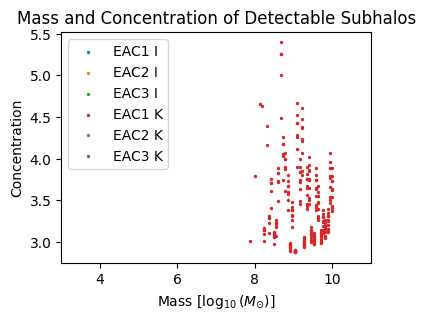

In [54]:
data_dir = '/data/bwedig/mejiro/hwo_subhalo_detection_compare'

f, ax = plt.subplots(figsize=(4, 3))

# ax.scatter(**get_scatter_kwargs(data_dir, 1, 'J'), s=2, alpha=0.5)
# ax.scatter(**get_scatter_kwargs(data_dir, 2, 'J'), s=2, alpha=0.5)
# ax.scatter(**get_scatter_kwargs(data_dir, 3, 'J'), s=2, alpha=0.5)
ax.scatter(**get_scatter_kwargs(data_dir, 1, 'I'), s=2)
ax.scatter(**get_scatter_kwargs(data_dir, 2, 'I'), s=2)
ax.scatter(**get_scatter_kwargs(data_dir, 3, 'I'), s=2)
# ax.scatter(**get_scatter_kwargs(data_dir, 1, 'H'), s=2, alpha=0.5)
# ax.scatter(**get_scatter_kwargs(data_dir, 2, 'H'), s=2, alpha=0.5)
# ax.scatter(**get_scatter_kwargs(data_dir, 3, 'H'), s=2, alpha=0.5)
ax.scatter(**get_scatter_kwargs(data_dir, 1, 'K'), s=2)
ax.scatter(**get_scatter_kwargs(data_dir, 2, 'K'), s=2)
ax.scatter(**get_scatter_kwargs(data_dir, 3, 'K'), s=2)

plt.xlabel(r'Mass [$\log_{10}(M_{\odot})$]')
plt.ylabel('Concentration')
plt.xlim(logm_low - 1, logm_high + 1)
plt.legend()
plt.title('Mass and Concentration of Detectable Subhalos')
plt.savefig(os.path.join(hwo_dir, 'figures', 'detectable_subhalos.png'))
plt.show()

In [55]:
def get_percent_detectable(m_list, detectable_halos):
    percent_det = []
    mlog10_list = [np.log10(m) for m in np.logspace(logm_low, logm_high, 100)]
    m_list = [np.log10(m) for m in m_list]

    for m in mlog10_list:
        count = np.sum(np.array(m_list) == m)
        percent_det.append(count / len(detectable_halos))

    return percent_det

In [56]:
def get_plot_kwargs(data_dir, eac, band):
    mlog10_list = [np.log10(m) for m in np.logspace(logm_low, logm_high, 100)]
    detectable_subhalos = util.unpickle_all(os.path.join(data_dir, f'eac{eac}_{band}'), 'detectable_halos_', '.pkl')
    z_list, m_list, c_list = get_detectable_subhalo_params(detectable_subhalos)
    return mlog10_list, get_percent_detectable(m_list, detectable_subhalos)

/tmp/ipykernel_281720/2597413828.py:8: RuntimeWarning: invalid value encountered in scalar divide
  percent_det.append(count / len(detectable_halos))


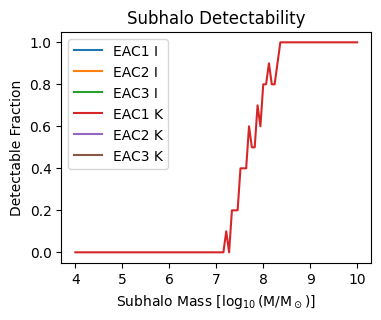

In [61]:
f, ax = plt.subplots(figsize=(4, 3))  # 
# ax.plot(*get_plot_kwargs(data_dir, 1, 'J'), label='EAC1 J')
# ax.plot(*get_plot_kwargs(data_dir, 2, 'J'), label='EAC2 J')
# ax.plot(*get_plot_kwargs(data_dir, 3, 'J'), label='EAC3 J')
ax.plot(*get_plot_kwargs(data_dir, 1, 'I'), label='EAC1 I')
ax.plot(*get_plot_kwargs(data_dir, 2, 'I'), label='EAC2 I')
ax.plot(*get_plot_kwargs(data_dir, 3, 'I'), label='EAC3 I')
# ax.plot(*get_plot_kwargs(data_dir, 1, 'H'), label='EAC1 H')
# ax.plot(*get_plot_kwargs(data_dir, 2, 'H'), label='EAC2 H')
# ax.plot(*get_plot_kwargs(data_dir, 3, 'H'), label='EAC3 H')
ax.plot(*get_plot_kwargs(data_dir, 1, 'K'), label='EAC1 K')
ax.plot(*get_plot_kwargs(data_dir, 2, 'K'), label='EAC2 K')
ax.plot(*get_plot_kwargs(data_dir, 3, 'K'), label='EAC3 K')
ax.legend()
ax.set_ylabel('Detectable Fraction')
ax.set_xlabel(r'Subhalo Mass [$\log_{10}($M/M$_\odot)$]')
plt.title('Subhalo Detectability')
plt.savefig(os.path.join(hwo_dir, 'figures', 'subhalo_detection_compare.png'))
plt.show()